In [19]:
import numpy as np
import matplotlib.pyplot as plt
import harmonica as hm
import verde as vd
import pandas as pd
import warnings

In [20]:
warnings.filterwarnings('ignore')

Gerando a malha dos levantamentos

Text(0, 1.02, 'b)')

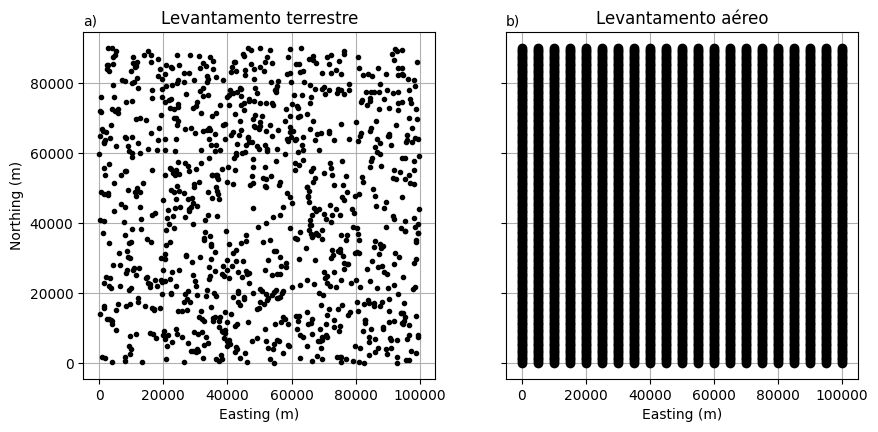

In [21]:
region = [0, 100e3, 0, 90e3]
# Coordenadas do levantamento terrestre
coordinates_t = vd.scatter_points(region, size=1000, extra_coords=1000, random_state=123)
# Espaçamento entre as linhas de voo
spacing = (500,5000) 
# Coordenadas do levantamento aéreo
coordinates_a = vd.grid_coordinates(region=region, spacing=spacing, extra_coords=500) 

fig, axes = plt.subplots(1,2,sharey=True, figsize=(10, 4.5)) #linha, coluna

axes[0].plot(coordinates_t[0], coordinates_t[1], ".k")
axes[0].set_ylabel("Northing (m)")
axes[0].set_xlabel("Easting (m)")
axes[0].grid()
axes[0].set_title("Levantamento terrestre")
axes[0].text(0,1.02,"a)", transform=axes[0].transAxes)
axes[1].plot(coordinates_a[0], coordinates_a[1],'o', color='black')
axes[1].set_xlabel("Easting (m)")
axes[1].grid()
axes[1].set_title("Levantamento aéreo")
axes[1].text(0,1.02,"b)", transform=axes[1].transAxes)


#plt.figure()
#plt.plot(coordinates_t[0], coordinates_t[1], ".k")
#plt.xlabel("Easting (m)")
#plt.ylabel("Northing (m)")
#plt.legend()
#plt.figure()
#plt.plot(coordinates_a[0], coordinates_a[1],'o', color='black')
#plt.xlabel("Easting (m)")
#plt.ylabel("Northing (m)")
#plt.legend()

In [22]:
# mudar o sintético 

# complicar o aereo
# perturbar as linhas
# adicionar linha de voo em sentido diferente 
# concatenar (np.concatenate e ravel)

Gerando o efeito gravitacional dos prismas

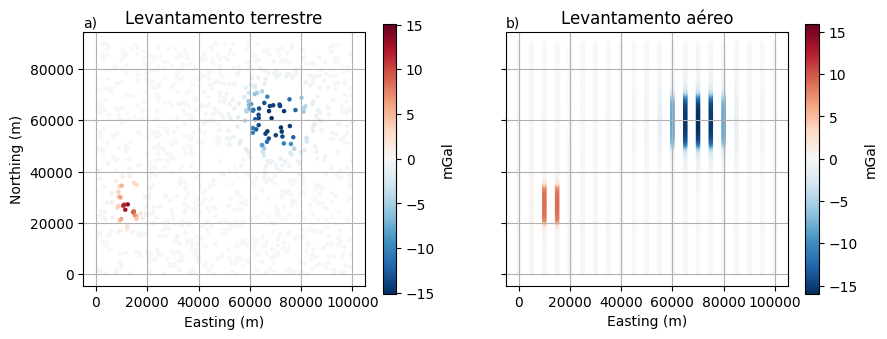

In [23]:
# Gerando os prismas 
prismas = [
    [10e3, 15e3, 20e3, 35e3, -1e3,  0],
    [60e3, 80e3, 50e3, 70e3, -2e3,  -0.5e3],
]
densidades = [500, -300]
# Efeito gravitacional dos prismas
gz_t = hm.prism_gravity(coordinates_t, prismas, densidades, field="g_z") # Terrestre
gz_a = hm.prism_gravity(coordinates_a, prismas, densidades, field="g_z") # Aéreo

fig, axes = plt.subplots(1,2,sharey=True, figsize=(10, 3.5)) #linha, coluna

escala = vd.maxabs(gz_t)
ax0 = axes[0].scatter(coordinates_t[0], coordinates_t[1], s=5, c=gz_t, cmap="RdBu_r", vmin=-escala, vmax=escala)
plt.colorbar(ax0, ax=axes[0], label="mGal")
axes[0].set_aspect("equal")
axes[0].set_ylabel("Northing (m)")
axes[0].set_xlabel("Easting (m)")
axes[0].grid()
axes[0].set_title("Levantamento terrestre")
axes[0].text(0,1.02,"a)", transform=axes[0].transAxes)

escala = vd.maxabs(gz_a)
ax1 = axes[1].scatter(coordinates_a[0],coordinates_a[1],s=5,c=gz_a, cmap="RdBu_r", vmin=-escala, vmax=escala)
plt.colorbar(ax1, ax=axes[1], label="mGal")
axes[1].set_aspect("equal")
axes[1].set_xlabel("Easting (m)")
axes[1].grid()
axes[1].set_title("Levantamento aéreo")
axes[1].text(0,1.02,"b)", transform=axes[1].transAxes)

plt.savefig('4.1.png', dpi=150)

Ajustando um modelo de fontes de equivalentes

In [24]:
# Ajustando modelo de fontes equivalentes ao levantamento terrestre
fontes_t = hm.EquivalentSourcesGB(damping=1,depth=2e3)
fontes_t.fit([coordinates_t[0],coordinates_t[1],coordinates_t[2]],data=gz_t)  

EquivalentSourcesGB(damping=1, depth=2000.0)

In [25]:
# Ajustando modelo de fontes equivalentes ao levantamento aéreo
fontes_a = hm.EquivalentSourcesGB(damping=1,depth=2e3)
fontes_a.fit([coordinates_a[0],coordinates_a[1],coordinates_a[2]],data=gz_a)

EquivalentSourcesGB(damping=1, depth=2000.0)

Gerando a malha do modelo de fontes equivalentes com espaçamento de 2000m

Text(0, 1.02, 'b)')

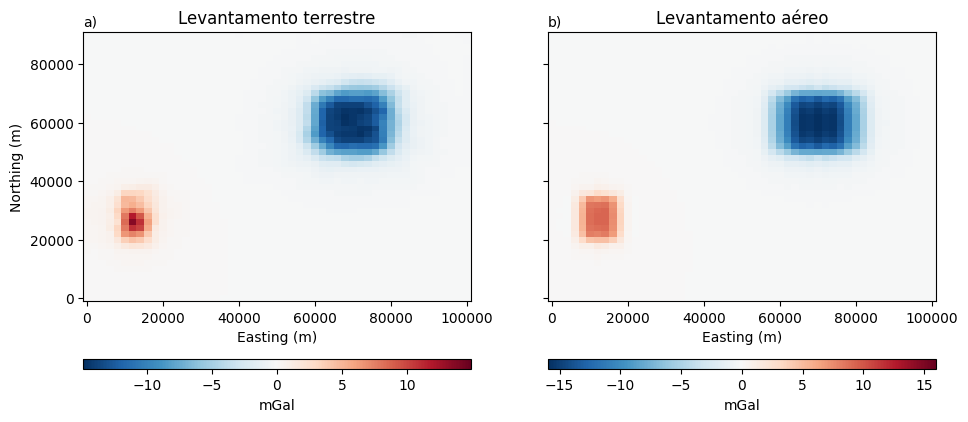

In [26]:
# Levantamento terrestre
grid_coords_eq_t = vd.grid_coordinates(region,spacing=2e3,extra_coords=1000)
gz_grid_eq_t = fontes_t.grid(grid_coords_eq_t,data_names="g_z")

# Levantamento aérero
grid_coords_eq_a = vd.grid_coordinates(region,spacing=2e3,extra_coords=500)
gz_grid_eq_a = fontes_a.grid(grid_coords_eq_a,data_names="g_z")

fig, axes = plt.subplots(1,2,sharey=True, figsize=(11, 5)) #linha, coluna

data1 = gz_grid_eq_t.g_z.plot(ax=axes[0],add_colorbar=False)
data2 = gz_grid_eq_a.g_z.plot(ax=axes[1],add_colorbar=False)

#axes[0].set_aspect("equal")
fig.colorbar(data1, ax=axes[0], orientation="horizontal", aspect=40, pad=0.15,label="mGal")
fig.colorbar(data2, ax=axes[1], orientation="horizontal", aspect=40, pad=0.15,label="mGal")

axes[0].set_ylabel("Northing (m)")
axes[0].set_xlabel("Easting (m)")
axes[0].set_title("Levantamento terrestre")
axes[0].text(0,1.02,"a)", transform=axes[0].transAxes)

axes[1].set_ylabel(" ")
axes[1].set_xlabel("Easting (m)")
axes[1].set_title("Levantamento aéreo")
axes[1].text(0,1.02,"b)", transform=axes[1].transAxes)
#plt.figure()
#gz_grid_eq_t.g_z.plot()
#plt.xlabel("Easting (m)")
#plt.ylabel("Northing (m)")
#plt.legend()
#plt.figure()
#gz_grid_eq_a.g_z.plot()
#plt.xlabel("Easting (m)")
#plt.ylabel("Northing (m)")
#plt.legend()


Reamostrando os dados numa malha regular ("verdadeira"). Objetivo: calcular o resíduo, ou seja, a diferença entre a malha "verdadeira" e a malha dos modelos de fontes equivalentes. 

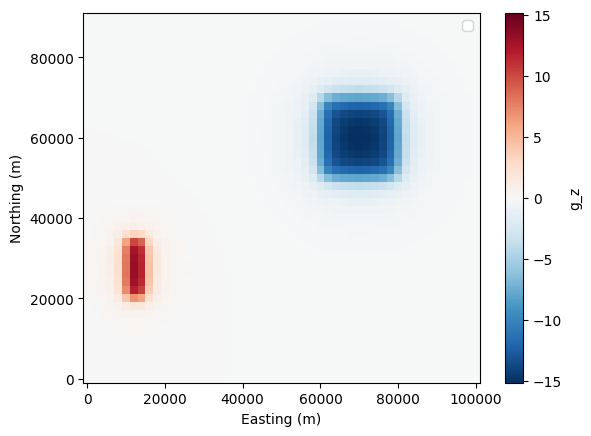

In [27]:
# Coordenadas da malha regular 
grid_coords = vd.grid_coordinates(region, spacing=2e3, extra_coords=1000)
# Efeito gravitacional dos prismas na malha regular
gz_grid = hm.prism_gravity(grid_coords, prismas, densidades, field="g_z")
# Malha regular: "verdadeira"
grid_true = vd.make_xarray_grid(grid_coords, gz_grid, data_names="g_z", extra_coords_names="upward")

grid_true.g_z.plot()
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.legend()

Resíduo.

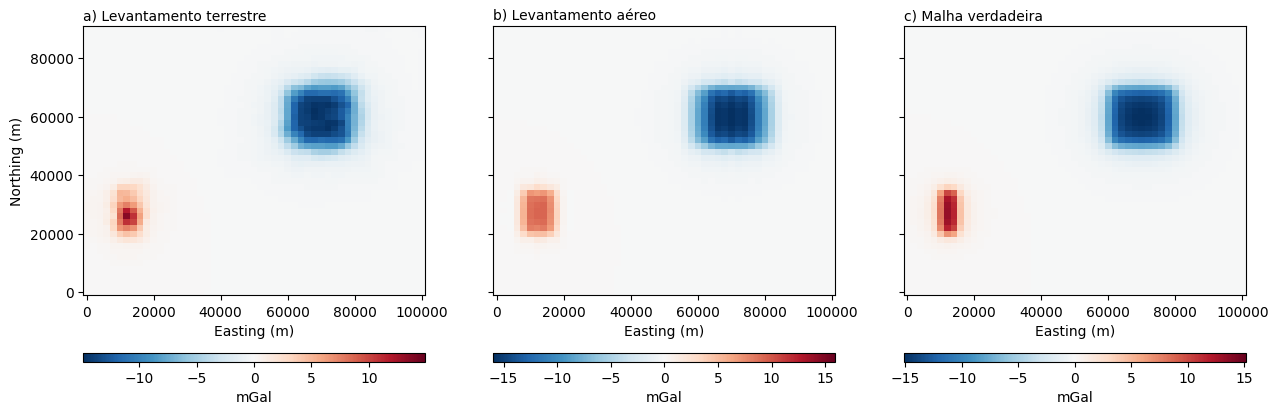

In [28]:
fig, axes = plt.subplots(1,3,sharey=True, figsize=(15, 5)) #linha, coluna

data1 = gz_grid_eq_t.g_z.plot(ax=axes[0],add_colorbar=False)
data2 = gz_grid_eq_a.g_z.plot(ax=axes[1],add_colorbar=False)
data3 = grid_true.g_z.plot(ax=axes[2],add_colorbar=False)

fig.colorbar(data1, ax=axes[0], orientation="horizontal", aspect=40, pad=0.15,label="mGal")
fig.colorbar(data2, ax=axes[1], orientation="horizontal", aspect=40, pad=0.15,label="mGal")
fig.colorbar(data3, ax=axes[2], orientation="horizontal", aspect=40, pad=0.15,label="mGal")

axes[0].set_ylabel("Northing (m)")
axes[0].set_xlabel("Easting (m)")
axes[0].text(0,1.02,"a) Levantamento terrestre", transform=axes[0].transAxes)

axes[1].set_ylabel(" ")
axes[1].set_xlabel("Easting (m)")
axes[1].text(0,1.02,"b) Levantamento aéreo", transform=axes[1].transAxes)

axes[2].set_ylabel(" ")
axes[2].set_xlabel("Easting (m)")
axes[2].text(0,1.02,"c) Malha verdadeira", transform=axes[2].transAxes)
plt.savefig('4.2.png', dpi=150)

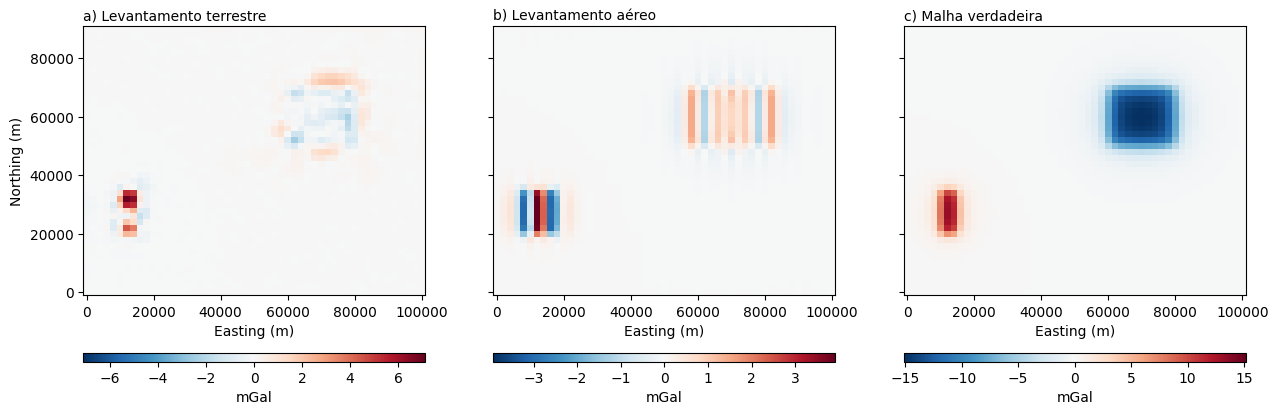

In [33]:
fig, axes = plt.subplots(1,3,sharey=True, figsize=(15, 5)) #linha, coluna

data1 = residuo_t.g_z.plot(ax=axes[0],add_colorbar=False)
data2 = residuo_a.g_z.plot(ax=axes[1],add_colorbar=False)
data3 = grid_true.g_z.plot(ax=axes[2],add_colorbar=False)

fig.colorbar(data1, ax=axes[0], orientation="horizontal", aspect=40, pad=0.15,label="mGal")
fig.colorbar(data2, ax=axes[1], orientation="horizontal", aspect=40, pad=0.15,label="mGal")
fig.colorbar(data3, ax=axes[2], orientation="horizontal", aspect=40, pad=0.15,label="mGal")

axes[0].set_ylabel("Northing (m)")
axes[0].set_xlabel("Easting (m)")
axes[0].text(0,1.02,"a) Levantamento terrestre", transform=axes[0].transAxes)

axes[1].set_ylabel(" ")
axes[1].set_xlabel("Easting (m)")
axes[1].text(0,1.02,"b) Levantamento aéreo", transform=axes[1].transAxes)

axes[2].set_ylabel(" ")
axes[2].set_xlabel("Easting (m)")
axes[2].text(0,1.02,"c) Malha verdadeira", transform=axes[2].transAxes)
plt.savefig('4.2.png', dpi=150)

Calculando o coeficiente R_2 verdadeiro

In [30]:
# Levantamento terrestre
g_z_medio_t = np.sum(gz_grid_eq_t.g_z.values)/np.size(gz_grid_eq_t.g_z)
residuo_quadrado_t = np.sum(residuo_t.g_z.values**2)
R_2_true_t = 1 - (residuo_quadrado_t/np.sum([(gz - g_z_medio_t)**2 for gz in gz_grid_eq_t.g_z.values]))
#R_2_true_t = 1 - (residuo_quadrado_t/np.sum((gz_grid_eq_t - g_z_medio_t)**2))


# Levantamento aéreo
g_z_medio_a = np.sum(gz_grid_eq_a.g_z.values)/np.size(gz_grid_eq_a.g_z)
residuo_quadrado_a = np.sum(residuo_a.g_z.values**2)
R_2_true_a = 1 - (residuo_quadrado_a/np.sum([(gz - g_z_medio_a)**2 for gz in gz_grid_eq_a.g_z.values]))

print(f"R² verdadeiro terrestre: {R_2_true_t}\n R² verdadeiro aéreo: {R_2_true_a}")

R² verdadeiro terrestre: 0.9750645523020796
 R² verdadeiro aéreo: 0.9784114959901214


Usando validação cruzada por blocos (block k-Fold) para avaliar quão bem o modelo de fontes equivalentes consegue prever com precisão os valores do campo

In [31]:
# Dados são primeiramente agrupados em blocos retangulares de tamanhos fornecimento pelo argumento "spacing".
# Os blocos são então divididos em teste e treinamento iterivamente através dos k folds do dado.
# (k é dado por "n_splits")


# Variando tamanho do bloco através de 5 folds do dado (n_splits = 5)

# Levantamento terrestre
block = np.arange(1000,10950,950) 
nsplits = 5
R_2_block_t = [] # Estou adicionando o valor médio de R²

for spacing in block:
    R_2_block_t.append(np.mean(
        vd.cross_val_score(
            fontes_t,
            coordinates_t,
            gz_t,
            cv=vd.BlockKFold(spacing=spacing, n_splits=nsplits, shuffle=True, random_state=123),
        )
    ))



In [32]:
# Levantamento aéreo
block = np.arange(1000,10950,950) 
nsplits = 5
R_2_block_a = [] # Estou adicionando o valor médio de R²

for spacing in block:
    R_2_block_a.append(np.mean(
        vd.cross_val_score(
            fontes_a,
            coordinates_a,
            gz_a,
            cv=vd.BlockKFold(spacing=spacing, n_splits=nsplits, shuffle=True, random_state=123),
        )
    ))


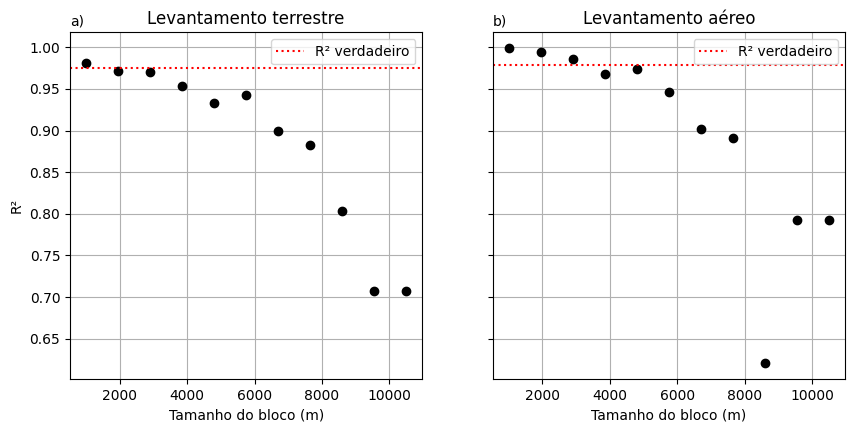

In [34]:
fig, axes = plt.subplots(1,2,sharey=True, figsize=(10, 4.5)) #linha, coluna

axes[0].plot(block,R_2_block_t,"o", color='black')
axes[0].set_ylabel("R²")
axes[0].set_xlabel("Tamanho do bloco (m)")
axes[0].grid()
axes[0].set_title("Levantamento terrestre")
axes[0].text(0,1.02,"a)", transform=axes[0].transAxes)
axes[0].axhline(y = R_2_true_t, color = 'red', linestyle = 'dotted', label="R² verdadeiro") 
axes[0].legend()
axes[0].grid(True)
axes[1].plot(block,R_2_block_a,"o", color='black')
axes[1].set_xlabel("Tamanho do bloco (m)")
axes[1].grid()
axes[1].set_title("Levantamento aéreo")
axes[1].text(0,1.02,"b)", transform=axes[1].transAxes)
axes[1].axhline(y = R_2_true_a, color = 'red', linestyle = 'dotted', label="R² verdadeiro") 
axes[1].legend()
axes[1].grid(True)
plt.savefig('4.4.png', dpi=150)

#plt.plot(block,R_2_block_t,"o")
#plt.xlabel("Tamanho do bloco (m)")
#plt.ylabel("R²")
#plt.axhline(y = R_2_true_t, color = 'red', linestyle = 'dotted', label="R² verdadeiro") 
#plt.grid(True)
#plt.legend()

#plt.plot(block,R_2_block_a,"o")
#plt.xlabel("Tamanho do bloco (m)")
#plt.ylabel("R²")
#plt.axhline(y = R_2_true_a, color = 'red', linestyle = 'dotted', label="R² verdadeiro") 
#plt.grid(True)
#plt.legend()

In [16]:
# Variando n_splits (numero de folds do dado)

# Levantamento terrestre: blocos de 1000m

R_2_splits_t = []
n = np.arange(2,9)
for n_splits in n:
    R_2_splits_t.append(np.mean(
        vd.cross_val_score(
            fontes_t,
            coordinates_t,
            gz_t,
            cv=vd.BlockKFold(spacing=1000, n_splits=n_splits, shuffle=True, random_state=123),
        )
    ))

In [17]:
# Levantamento aéreo: blocos de 1000m

R_2_splits_a = []
n = np.arange(2,9)
for n_splits in n:
    R_2_splits_a.append(np.mean(
        vd.cross_val_score(
            fontes_a,
            coordinates_a,
            gz_a,
            cv=vd.BlockKFold(spacing=2000, n_splits=n_splits, shuffle=True, random_state=123),
        )
    ))

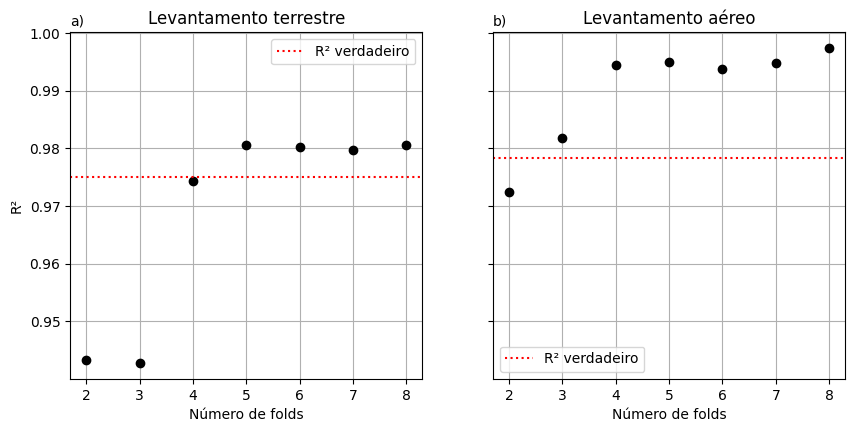

In [18]:
fig, axes = plt.subplots(1,2,sharey=True, figsize=(10, 4.5)) #linha, coluna

n=list(n)
axes[0].plot(n,R_2_splits_t,"o", color='black')
axes[0].set_ylabel("R²")
axes[0].set_xlabel("Número de folds")
axes[0].grid()
axes[0].set_title("Levantamento terrestre")
axes[0].text(0,1.02,"a)", transform=axes[0].transAxes)
axes[0].axhline(y = R_2_true_t, color = 'red', linestyle = 'dotted', label="R² verdadeiro") 
axes[0].legend()
axes[0].grid(True)
axes[1].plot(n,R_2_splits_a,"o", color='black')
axes[1].set_xlabel("Número de folds")
axes[1].grid()
axes[1].set_title("Levantamento aéreo")
axes[1].text(0,1.02,"b)", transform=axes[1].transAxes)
axes[1].axhline(y = R_2_true_a, color = 'red', linestyle = 'dotted', label="R² verdadeiro") 
axes[1].legend()
axes[1].grid(True)